In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
data = np.load('data/processed_data.npz')
X_train_flat = data['X_train_flat']
X_test_flat = data['X_test_flat']
X_train_img = data['X_train_img'] # (N, 1, 28, 28)
X_test_img = data['X_test_img']   # (N, 1, 28, 28)

print("Data loaded.")

Data loaded.


In [ ]:
# Define PyTorch Models
class DenseAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU() # Latent representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid() # Output [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: (N, 1, 28, 28)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # -> (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32, 7, 7)
            nn.ReLU(),
            nn.Flatten(), # -> 32*7*7 = 1568
            nn.Linear(32 * 7 * 7, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder_fc(encoded)
        decoded = self.decoder_conv(x)
        return decoded, encoded

In [ ]:
# Training Utility Function

def train_model(model, train_data, test_data, epochs=5, batch_size=256):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Create DataLoaders
    train_tensor = torch.Tensor(train_data)
    test_tensor = torch.Tensor(test_data)
    
    train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                
        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        
    return val_losses[-1], model # Return final val loss and trained model

In [ ]:
# Architecture Search Loop

latent_dims = [4, 8, 16, 32, 64]
history_log = []

print("Starting Architecture Search...")

for dim in latent_dims:
    # 1. Test Dense AE
    print(f"\nTraining Dense AE (Latent: {dim})...")
    model = DenseAutoencoder(latent_dim=dim)
    val_loss_dense, _ = train_model(model, X_train_flat, X_test_flat, epochs=5)
    
    # 2. Test Conv AE
    print(f"Training Conv AE (Latent: {dim})...")
    model = ConvAutoencoder(latent_dim=dim)
    val_loss_conv, _ = train_model(model, X_train_img, X_test_img, epochs=5)
    
    history_log.append({
        'latent_dim': dim,
        'dense_loss': val_loss_dense,
        'conv_loss': val_loss_conv
    })

print("\nSearch Complete.")

Starting Architecture Search...

Training Dense AE (Latent: 4)...
Training Conv AE (Latent: 4)...

Training Dense AE (Latent: 8)...
Training Conv AE (Latent: 8)...

Training Dense AE (Latent: 16)...
Training Conv AE (Latent: 16)...

Training Dense AE (Latent: 32)...
Training Conv AE (Latent: 32)...

Training Dense AE (Latent: 64)...
Training Conv AE (Latent: 64)...

Search Complete.


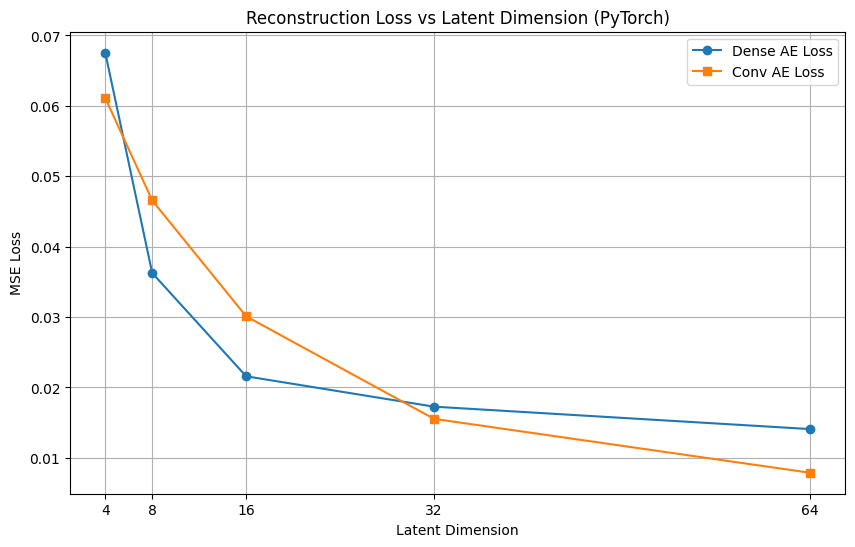

In [ ]:
# Visualize Results

results_df = pd.DataFrame(history_log)

plt.figure(figsize=(10, 6))
plt.plot(results_df['latent_dim'], results_df['dense_loss'], marker='o', label='Dense AE Loss')
plt.plot(results_df['latent_dim'], results_df['conv_loss'], marker='s', label='Conv AE Loss')
plt.title('Reconstruction Loss vs Latent Dimension (PyTorch)')
plt.xlabel('Latent Dimension')
plt.ylabel('MSE Loss')
plt.xticks(latent_dims)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Train and Save Best Models
# We save the entire model object for simplicity in loading later, 

BEST_DIM = 32
print(f"Training Final Models with Dim {BEST_DIM}...")

# Dense
dense_model = DenseAutoencoder(BEST_DIM)
_, dense_model = train_model(dense_model, X_train_flat, X_test_flat, epochs=15)
torch.save(dense_model, f'models/dense_ae_{BEST_DIM}.pth')

# Conv
conv_model = ConvAutoencoder(BEST_DIM)
_, conv_model = train_model(conv_model, X_train_img, X_test_img, epochs=15)
torch.save(conv_model, f'models/conv_ae_{BEST_DIM}.pth')

print("Models saved to 'models/' as .pth files")

Training Final Models with Dim 32...
Models saved to 'models/' as .pth files
